In [2]:
%pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 23.4 MB/s  0:00:05 eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
%pip install matplotlib

  Using cached matplotlib-3.10.8-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached matplotlib-3.10.8-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp313-cp313-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (4.9 MB)
Using ca

In [3]:
import os
import torch
import itertools
import gc
import bitsandbytes as bnb
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model
from torchvision import transforms
from PIL import Image
from accelerate import Accelerator

# --- CONFIGURATION ---
DEFAULT_PROMPT = "a photo of tiry person" 
CLASS_DIR = "tiry_pics_processed" 
OUTPUT_DIR = "sd-tiry-lora-xmas"        
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
RESOLUTION = 512

# 90 images * 110 Epochs / 4 Batch Size ~= 2500 Steps
TRAIN_STEPS = 2500       
BATCH_SIZE = 4           # Keep Batch 4 for speed
ACCUMULATION_STEPS = 1   
LEARNING_RATE = 1e-4

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
accelerator = Accelerator(
    mixed_precision="fp16",
    gradient_accumulation_steps=ACCUMULATION_STEPS 
)
# should have selected cuda
print("Accelerator device:", accelerator.device)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))

# --- PHASE 1: PRE-PROCESSING ---
print("PHASE 1: Encoding Images...")

tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder").to(accelerator.device)
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae").to(accelerator.device)

train_transforms = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

cached_data = []
# gather images
image_files = [f for f in os.listdir(CLASS_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for filename in image_files:
    # 1. Load Image
    img_path = os.path.join(CLASS_DIR, filename)
    img = Image.open(img_path).convert("RGB")
    # load img to GPU
    pixel_values = train_transforms(img).unsqueeze(0).to(accelerator.device)
    
    # 2. Load Caption 
    txt_path = os.path.splitext(img_path)[0] + ".txt"
    caption = DEFAULT_PROMPT # Default start
    
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            caption = f.read().strip()
    else:
        print(f"⚠️ Warning: No caption found for {filename}. Using default.")
    
    # 3. Encode Image (Latents /VAE )
    with torch.no_grad():
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        # free vram ?
        latents = latents.cpu()
        
    # 4. Encode Specific Caption (Embeddings)
    input_ids = tokenizer(
        caption, # Use the specific text for this image
        padding="max_length", 
        truncation=True, 
        max_length=tokenizer.model_max_length, 
        return_tensors="pt"
    ).input_ids.to(accelerator.device)
    
    with torch.no_grad():
        encoder_hidden_states = text_encoder(input_ids)[0].cpu()
        
    # we cache data computed in latent space for later use during training to be able to free everything else 
    # not 100% sure this is needed, but it helped when I was having steam playing tricks in the background :(
    cached_data.append({"latents": latents, "embeds": encoder_hidden_states})

del vae, text_encoder, tokenizer
torch.cuda.empty_cache()
gc.collect()

# --- PHASE 2: TRAINING ---
print(f"\nPHASE 2: Starting Training ({TRAIN_STEPS} Steps, Batch {BATCH_SIZE})...")

unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")

#freeze unet
unet.requires_grad_(False)

# vram usage optimization - may not be always needed
unet.enable_gradient_checkpointing()
try:
    unet.enable_xformers_memory_efficient_attention()
except:
    pass

# TARGET MODULES
target_modules = [
    "to_k", "to_q", "to_v", "to_out.0", # attention layers
    "proj_in", "proj_out",              # feed forward 
    "ff.net.0.proj", "ff.net.2", 
    "time_emb_proj"
]

# 2. ALPHA = 128 (MASSIVE SIGNAL BOOST)
lora_config = LoraConfig(
    r=32,            # rank                           
    lora_alpha=128,  # High Signal Strength
    target_modules=target_modules,
    init_lora_weights="gaussian",
)
unet = get_peft_model(unet, lora_config)
optimizer = bnb.optim.AdamW8bit(unet.parameters(), lr=LEARNING_RATE)

# move to GPU hopefully
unet, optimizer = accelerator.prepare(unet, optimizer)

# BATCH DATALOADER
class CachedDataset(torch.utils.data.Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

def collate_fn(examples):
    latents = torch.cat([ex["latents"] for ex in examples], dim=0)
    embeds = torch.cat([ex["embeds"] for ex in examples], dim=0)
    return {"latents": latents, "embeds": embeds}

train_dataloader = torch.utils.data.DataLoader(
    CachedDataset(cached_data), 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn
)
unet.train()
#data_iter = itertools.cycle(cached_data)
data_iter = itertools.cycle(train_dataloader)


for step in range(TRAIN_STEPS):
    batch = next(data_iter)
    
    latents = batch["latents"].to(accelerator.device, dtype=torch.float16)
    embeds = batch["embeds"].to(accelerator.device, dtype=torch.float16)
    
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    # predict noise
    model_pred = unet(noisy_latents, timesteps, embeds).sample
    # compute loss
    loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
    # Backprop + optimizer step
    accelerator.backward(loss)
    optimizer.step()
    optimizer.zero_grad(set_to_none=True)
    
    if step % 200 == 0:
        print(f"   Step {step}/{TRAIN_STEPS} | Loss: {loss.item():.4f}")

print("\n✅ Training Complete!")
unet.save_pretrained(OUTPUT_DIR)

🏗️ PHASE 1: Encoding Images...

🚀 PHASE 2: Starting Training (2500 Steps, Batch 4)...
   Step 0/2500 | Loss: 0.1620
   Step 200/2500 | Loss: 0.2447
   Step 400/2500 | Loss: 0.1078
   Step 600/2500 | Loss: 0.2711
   Step 800/2500 | Loss: 0.0971
   Step 1000/2500 | Loss: 0.3100
   Step 1200/2500 | Loss: 0.1175
   Step 1400/2500 | Loss: 0.0289
   Step 1600/2500 | Loss: 0.0824
   Step 1800/2500 | Loss: 0.1465
   Step 2000/2500 | Loss: 0.1677
   Step 2200/2500 | Loss: 0.2238
   Step 2400/2500 | Loss: 0.0795

✅ Training Complete!


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

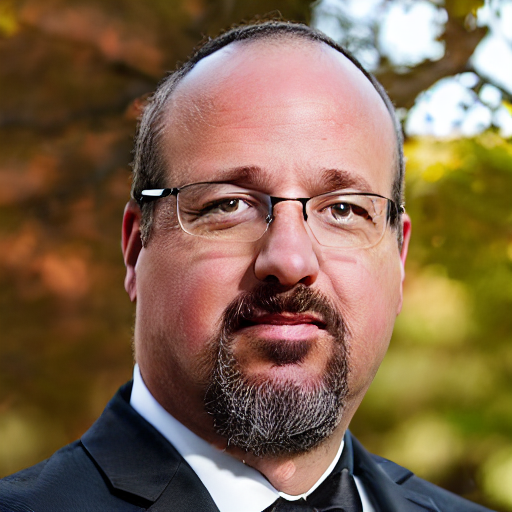

In [4]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker=None).to("cuda")
pipe.unet = PeftModel.from_pretrained(pipe.unet, "sd-tiry-lora-xmas") # Load v2
pipe.unet.to("cuda")

# TRIGGER: "ohwx person"
prompt = "A professional headshot of tiry person in a suit, 8k, sharp focus, cinematic lighting, detailed eyes"
image = pipe(prompt, negative_prompt="blur, low quality, distortion, ugly", num_inference_steps=50).images[0]
display(image)

Loading Base Model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading LoRA from sd-tiry-lora-xmas...

Generating Test Grid...
   Generating Scale 0.8...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 0.9...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.0...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.1...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating Scale 1.2...


  0%|          | 0/50 [00:00<?, ?it/s]

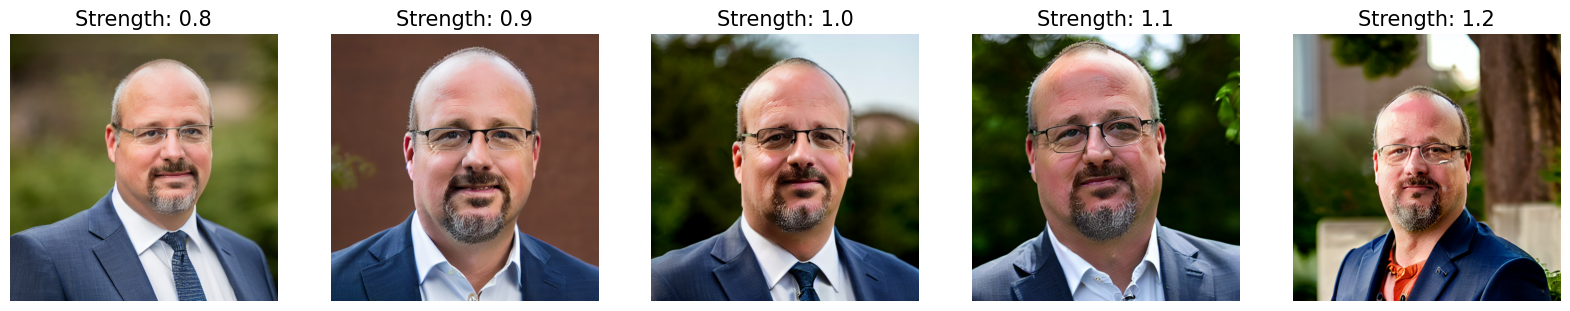

In [5]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import matplotlib.pyplot as plt

# 1. Load Base
print("Loading Base Model...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# 2. Load Your Precision LoRA
LORA_DIR = "sd-tiry-lora-xmas"
print(f"Loading LoRA from {LORA_DIR}...")
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_DIR)
pipe.unet.to("cuda")

# 3. Setup The Test
prompt = "A professional headshot of tiry person in a suit, 8k, sharp focus, cinematic lighting"
negative_prompt = "cartoon, drawing, anime, blur, low quality, distortion, ugly, deformed"
scales = [0.8, 0.9, 1.0, 1.1, 1.2] # Testing stronger weights

print("\nGenerating Test Grid...")
images = []
titles = []

for scale in scales:
    print(f"   Generating Scale {scale}...")
    image = pipe(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        num_inference_steps=50,
        guidance_scale=7.5,
        cross_attention_kwargs={"scale": scale} # The Magic Lever
    ).images[0]
    
    images.append(image)
    titles.append(f"Strength: {scale}")

# 4. Display Side-by-Side
fig, axs = plt.subplots(1, 5, figsize=(20, 6))
for i, (img, title) in enumerate(zip(images, titles)):
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=15)
    axs[i].axis("off")
plt.show()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating Showcase...
   Generating: A professional headshot of tir...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating: A candid photo of tiry person ...


  0%|          | 0/50 [00:00<?, ?it/s]

   Generating: Oil painting of tiry person as...


  0%|          | 0/50 [00:00<?, ?it/s]

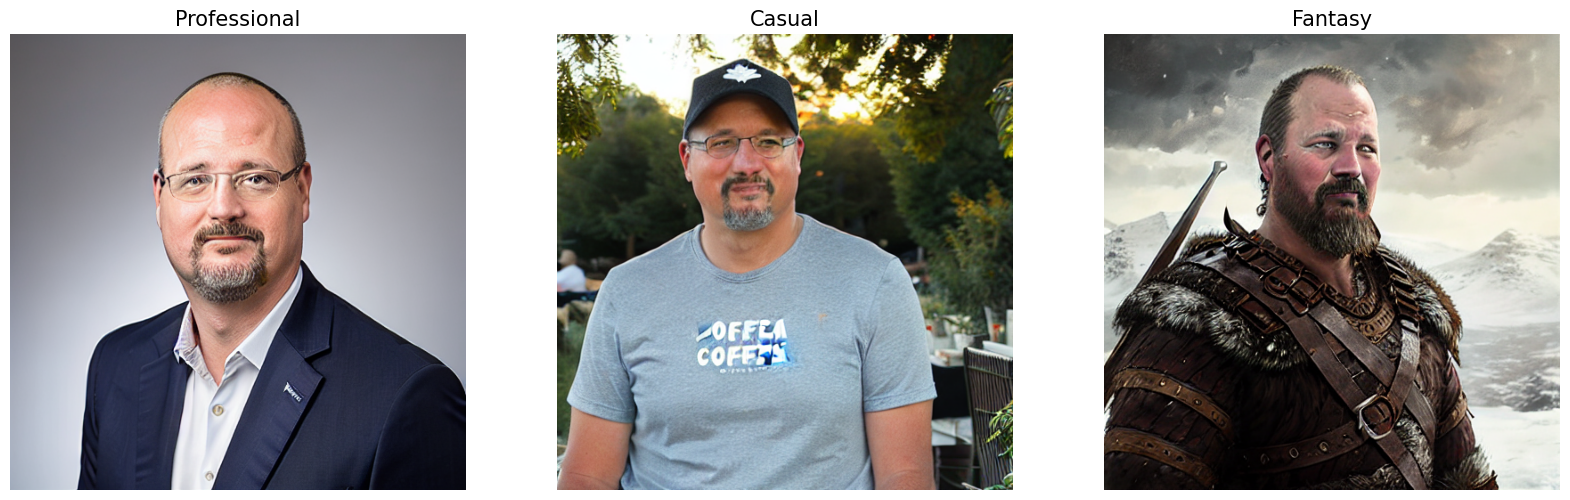

In [7]:
import torch
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import matplotlib.pyplot as plt

# 1. Load Base
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16, 
    safety_checker=None
).to("cuda")

# 2. Load the Final LoRA
LORA_DIR = "sd-tiry-lora-xmas"
pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_DIR)
pipe.unet.to("cuda")

# 3. The Three Styles
prompts = [
    # 1. Professional (The "LinkedIn" test)
    "A professional headshot of tiry person in a navy blue suit, white shirt, studio lighting, 8k, sharp focus, canon 5d",
    
    # 2. Casual (The "Reality" test)
    "A candid photo of tiry person wearing a t-shirt at a coffee shop, golden hour lighting, depth of field, bokeh",
    
    # 3. Fantasy (The "Stylization" test)
    "Oil painting of tiry person as a viking warrior, fur armor, snow storm background, intricate beard detail, artstation, greg rutkowski"
]

negative_prompt = "cartoon, drawing, anime, blur, low quality, distortion, ugly, deformed, extra fingers"

print("Generating Showcase...")
images = []
for p in prompts:
    print(f"   Generating: {p[:30]}...")
    # Scale 1.0 should work now. If slightly too strong, try 0.9.
    img = pipe(p, negative_prompt=negative_prompt, num_inference_steps=50, cross_attention_kwargs={"scale": 1.0}).images[0]
    images.append(img)

# 4. Display
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
titles = ["Professional", "Casual", "Fantasy"]
for i, (img, title) in enumerate(zip(images, titles)):
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=15)
    axs[i].axis("off")
plt.show()